In [1]:
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
from upsetplot import UpSet

In [27]:
## Some utility functions
def get_circminer(circ_file, min_ccr=1):
    names=["chrom", "start", "end", "nccr", "type", "cons_splice", "splice", "pass", "supp_reads"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_circeplorer(circ_file, min_ccr=1):
    names=["chrom", "start", "end", "name", "score", "strand", "thickStart", 
           "thickEnd", "itemRgb", "exonCount", "exonSizes", "exonOffsets", 
           "readNumber", "circType", "geneName", "isoformName", "exonIndex/intronIndex", 
           "flankIntron"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas['start'] = circrnas['start'] + 1
    circrnas = circrnas.rename(columns={"readNumber": "nccr"})
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_circeplorer2(circ_file, min_ccr=1):
    return get_circeplorer(circ_file, min_ccr)

def get_dcc(circ_file, min_ccr=1):
    circrnas = pd.read_csv(circ_file, sep="\t")
    circrnas = circrnas.rename(columns={"Chr": "chrom", "Start": "start", "End": "end", 
                                        "Chimeric.out.junction": "nccr"})
    circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def get_cirminer(circ_file, min_ccr=1):
    names=["chrom","start","end","nccr","type","cons_splice", "splice", "pass", "supp_reads"]
    circrnas = pd.read_csv(circ_file, sep="\t", names=names)
    circrnas = circrnas = circrnas[circrnas['nccr']>=min_ccr]
    return circrnas.sort_values(["chrom", "start"])

def set_key(record):
    return "-".join(map(str, [record["chrom"], record["start"], record["end"]]))

def get_keys(circrnas):
    circrnas_dict = defaultdict()
    for index, row in circrnas.iterrows():
        circrnas_dict[set_key(row)] = row
    circ_keys = set(circrnas_dict.keys())
    return circ_keys

def get_all_keys(circrnas):
    circ_keys = defaultdict()
    for tool, circs in circrnas.items():
        circ_keys[tool] = get_keys(circs)
    return circ_keys

def getRNaseCirc(condition, min_ccr=1):
    circexplorer = get_circeplorer("circrnas/"+condition+"/circexplorer_circ.txt", min_ccr)
    circexplorer2 = get_circeplorer2("circrnas/"+condition+"/circexplorer2_circrna.txt", min_ccr)
    dcc = get_dcc("circrnas/"+condition+"/dcc/CircRNACount", min_ccr)
    circminer = get_cirminer("circrnas/"+condition+"/circminer.circ_report", min_ccr=min_ccr)
    circrnas = {"CIRCexplorer": circexplorer, "CIRCexplorer2": circexplorer2, "DCC": dcc, 
                "Circminer": circminer}
    return circrnas

def get_support(circrnas):
    circ_keys = get_all_keys(circrnas)
    sorted_tools = sorted(circ_keys.keys())
    all_ids = set.union(*circ_keys.values())
    tool_support = []
    for circ in all_ids:
        counter = [True]
        for tool in sorted_tools:
            counter.append(True if circ in circ_keys[tool] else False)
        counter.append(circ)
        tool_support.append(counter)
    df = pd.DataFrame.from_records(tool_support,columns=["Union"] + sorted_tools +["id"])
    df = df.set_index(tools)
    return df

def get_not_depleted(circrnas, tools):
    after = get_all_keys(circrnas["HeLaR+"])
    before = get_all_keys(circrnas["HeLaR-"])
    sorted_tools = sorted(circrnas.keys())
    not_depleted = []
    percent_not_depleted = []
    for tool in tools:
        not_deple = after[tool] & before[tool]
        not_depleted.append(len(not_deple))
        percent_not_depleted.append(len(not_deple)/len(before[tool]))
    return {"Not depleted": not_depleted, "Not depleted (%)": percent_not_depleted}

In [3]:
treatments = ["HeLaR-", "HeLaR+"]
min_ccr = 2
rnas = defaultdict()
rnas["HeLaR-"] = getRNaseCirc("HeLaRminus", min_ccr=min_ccr)
rnas["HeLaR+"] = getRNaseCirc("HeLaRplus", min_ccr=min_ccr)

In [28]:
tools = ["Circminer", "CIRCexplorer", "CIRCexplorer2", "DCC"]
treatments = ["HeLaR-", "HeLaR+"]
calls = defaultdict(list)
for condition in treatments:
    for tool in tools:
        calls[condition].append(len(rnas[condition][tool]))
calls['tool'] = tools
calls.update(get_not_depleted(rnas, tools))

#### Detailed comparison or circ detection tools

In [30]:
df = pd.DataFrame(calls).set_index("tool")
df

,HeLaR-,HeLaR+,Not depleted,Not depleted (%)
tool,,,,
Circminer,6170,7518,3247,0.526256
CIRCexplorer,3446,5445,1873,0.543529
CIRCexplorer2,3446,5445,1873,0.543529
DCC,5343,6258,2410,0.451057


In [ ]:
support = get_support(rnas["HeLaR-"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tools true positives\n",fontsize=15)

In [ ]:
support = get_support(rnas["HeLaR+"])
fig = plt.figure(figsize=(100, 20))
upset = UpSet(support, subset_size='count', sort_by="cardinality", show_counts='%d', element_size=55)
upset.plot(fig = fig)
temp = plt.title("Tools true positives\n",fontsize=15)

In [34]:
rnas["HeLaR+"]['DCC']

,chrom,start,end,nccr
0,1,805799,810170,2
1,1,925922,939412,3
2,1,935772,939412,4
10,1,1256045,1263386,2
12,1,1256992,1257310,4
...,...,...,...,...
22291,X,154769167,154770879,3
22293,X,154789954,154792285,2
22295,X,155220183,155238859,2
22297,X,155415575,155419562,16


In [44]:
dcc_selected = get_keys(rnas["HeLaR+"]['DCC'])
circrnas = pd.read_csv("circrnas/HeLaRplus/dcc/CircCoordinates", sep="\t")
circrnas = circrnas.rename(columns={"Chr": "chrom", "Start": "start", "End": "end"})
circrnas_sel = []
for index, row in circrnas.iterrows():
    circ_key = set_key(row)
    circrnas_sel.append(circ_key in dcc_selected)
circrnas = circrnas[circrnas_sel]

In [112]:
circrnas_annot = []
for index, row in circrnas.iterrows():
    annot = row['Start-End Region']
    reannot = "-".join(sorted(annot.split('-')))
    if ("intron" in annot or "exon" in annot) and "intergenic" in annot:
        reannot = "mixed"
    elif "intron" in annot:
        reannot = "intron"
    elif "intergenic" in annot:
        reannot = "intergenic"
    circrnas_annot.append(reannot)
circrnas['annotation'] = circrnas_annot

In [113]:
sizes = circrnas.groupby("annotation").size() 

array(['exon-exon', 'intergenic', 'intron', 'mixed'], dtype=object)

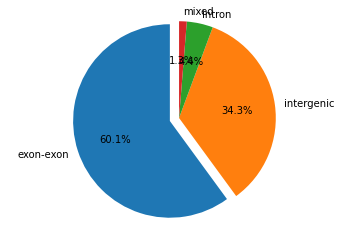

In [115]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = sizes.index.values
pie_sizes = sizes.values
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(pie_sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [116]:
dcc_selected = get_keys(rnas["HeLaR-"]['DCC'])
circrnas = pd.read_csv("circrnas/HeLaRplus/dcc/CircCoordinates", sep="\t")
circrnas = circrnas.rename(columns={"Chr": "chrom", "Start": "start", "End": "end"})
circrnas_sel = []
for index, row in circrnas.iterrows():
    circ_key = set_key(row)
    circrnas_sel.append(circ_key in dcc_selected)
circrnas = circrnas[circrnas_sel]

In [117]:
circrnas_annot = []
for index, row in circrnas.iterrows():
    annot = row['Start-End Region']
    reannot = "-".join(sorted(annot.split('-')))
    if ("intron" in annot or "exon" in annot) and "intergenic" in annot:
        reannot = "mixed"
    elif "intron" in annot:
        reannot = "intron"
    elif "intergenic" in annot:
        reannot = "intergenic"
    circrnas_annot.append(reannot)
circrnas['annotation'] = circrnas_annot

In [118]:
sizes = circrnas.groupby("annotation").size() 

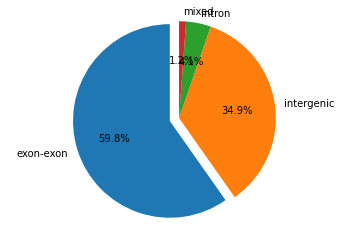

In [119]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = sizes.index.values
pie_sizes = sizes.values
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(pie_sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()